# Data analysis
In this iPython notebook, we analyse the data produced by the basic stock market model

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import ast
style.use('seaborn-darkgrid')

First, I open a connection to the database

In [4]:
%cd C:/Users/joerischasfoort/Documents/GitHub/abm/stockmarket

C:\Users\joerischasfoort\Documents\GitHub\abm\stockmarket


In [5]:
conn = sqlite3.connect('dataBaseOffline.sqlite')
cur = conn.cursor()

## 1 State variables 
Using the Statevariables, Variabletypes and Objects tables, I then analyse the state variables of the simulated objects: stocks, firms, and traders. 
### 1.1 Stocks 
The state variables of stocks are: 
* the firm the stock links to,
* the face value,
* the amount of stocks outstanding. 

In this version of the model these variables are static. 

In [21]:
stockVariables = pd.read_sql_query(
    """
    SELECT Statevariables.period, Variabletypes.variable_type, Objects.object_name, Objects.object_type ,Statevariables.value 
    FROM Statevariables JOIN Variabletypes JOIN Objects ON Statevariables.variable_id = Variabletypes.id and Statevariables.owner_id = Objects.id 
    WHERE Objects.object_type = 'stock'
    """, conn)

In [22]:
stockVariables.head()

,period,variable_type,object_name,object_type,value
0,0,face_value,stock_0,stock,50
1,0,firm,stock_0,stock,0
2,0,price_history,stock_0,stock,[]
3,0,amount,stock_0,stock,200
4,0,name,stock_0,stock,0


In [23]:
stock_0 = stockVariables.query('variable_type == "amount" and object_name == "stock_0"')['value']
stock_1 = stockVariables.query('variable_type == "amount" and object_name == "stock_1"')['value']
stock_2 = stockVariables.query('variable_type == "amount" and object_name == "stock_2"')['value']
stock_3 = stockVariables.query('variable_type == "amount" and object_name == "stock_3"')['value']
time = stockVariables.query('variable_type == "amount" and object_name == "stock_0"')['period']

In [24]:
face_value_0 = stockVariables.query('variable_type == "face_value" and object_name == "stock_0"')['value']
face_value_1 = stockVariables.query('variable_type == "face_value" and object_name == "stock_1"')['value']
face_value_2 = stockVariables.query('variable_type == "face_value" and object_name == "stock_2"')['value']
face_value_3 = stockVariables.query('variable_type == "face_value" and object_name == "stock_3"')['value']

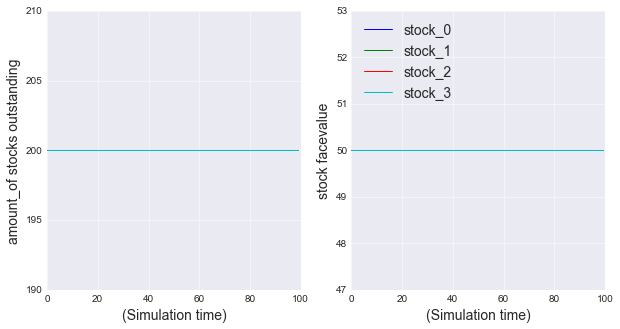

In [25]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(time, stock_0, label='stock_0')
ax1.plot(time, stock_1, label='stock_1')
ax1.plot(time, stock_2, label='stock_2')
ax1.plot(time, stock_3, label='stock_3')

ax2.plot(time, face_value_0, label='stock_0')
ax2.plot(time, face_value_1, label='stock_1')
ax2.plot(time, face_value_2, label='stock_2')
ax2.plot(time, face_value_3, label='stock_3')

ax1.set_xlabel('(Simulation time)', fontsize='14')
ax2.set_xlabel('(Simulation time)', fontsize='14')
ax1.set_ylabel('amount_of stocks outstanding', fontsize='14')
ax2.set_ylabel('stock facevalue', fontsize='14')

plt.legend(loc=2, fontsize='14')

### 1.2 Firms 
The state variables of firms are: 
* profit
* Bookvalue,
* Dividend rate.

In [26]:
firmVariables = pd.read_sql_query(
    """
    SELECT Statevariables.period, Variabletypes.variable_type, Objects.object_name, Objects.object_type, Statevariables.value 
    FROM Statevariables JOIN Variabletypes JOIN Objects 
    ON Statevariables.variable_id = Variabletypes.id and Statevariables.owner_id = Objects.id 
    WHERE Objects.object_type = 'firm'
    """, conn)

In [27]:
firmVariables.head()

,period,variable_type,object_name,object_type,value
0,0,profit,firm_0,firm,202
1,0,profit_history,firm_0,firm,"[200, 208, 197, 193, 202]"
2,0,dividend_rate,firm_0,firm,1
3,0,book_value,firm_0,firm,10000
4,0,name,firm_0,firm,0


In [28]:
firm_0 = firmVariables.query('variable_type == "profit" and object_name == "firm_0"')['value']
firm_1 = firmVariables.query('variable_type == "profit" and object_name == "firm_1"')['value']
firm_2 = firmVariables.query('variable_type == "profit" and object_name == "firm_2"')['value']
firm_3 = firmVariables.query('variable_type == "profit" and object_name == "firm_3"')['value']
f_time = firmVariables.query('variable_type == "profit" and object_name == "firm_0"')['period']

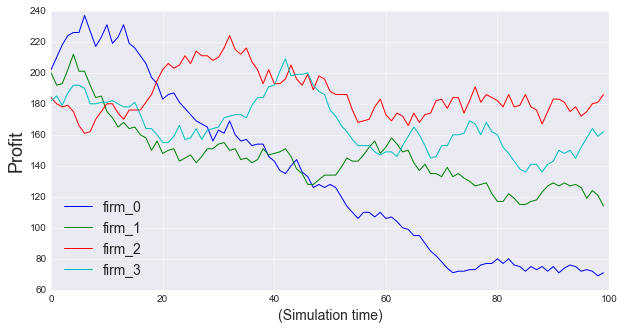

In [29]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

ax1.plot(f_time, firm_0, label='firm_0')
ax1.plot(f_time, firm_1, label='firm_1')
ax1.plot(f_time, firm_2, label='firm_2')
ax1.plot(f_time, firm_3, label='firm_3')

ax1.set_xlabel('(Simulation time)', fontsize='14')
ax1.set_ylabel('Profit', fontsize='18')

plt.legend(loc='best', fontsize='14')

### 1.3 Traders

In this section, we examine the state variables of traders. These are: 
* Money
* Portfolio of stocks: *The type and amount of that stock agent holds*
* Bid-ask spread: *the percentage difference between the amount at which an agent is willing to buy and sell a stock.*
* Memory size: *the amount of periods an agent remembers stock prices*

In [30]:
traderVariables = pd.read_sql_query(
    """
    SELECT Statevariables.period, Variabletypes.variable_type, Objects.object_name, Objects.object_type, Statevariables.value 
    FROM Statevariables JOIN Variabletypes JOIN Objects 
    ON Statevariables.variable_id = Variabletypes.id and Statevariables.owner_id = Objects.id 
    WHERE Objects.object_type = 'trader'
    """, conn)

In [31]:
traderVariables['object_name'].unique()

array(['trader_0', 'trader_1', 'trader_2', 'trader_3', 'trader_4',
       'trader_5', 'trader_6', 'trader_7', 'trader_8', 'trader_9',
       'trader_10', 'trader_11', 'trader_12', 'trader_13', 'trader_14',
       'trader_15', 'trader_16', 'trader_17', 'trader_18', 'trader_19'], dtype=object)

In [32]:
traderVariables.head()

,period,variable_type,object_name,object_type,value
0,0,money,trader_0,trader,117
1,0,stocks,trader_0,trader,"{stock_0: 10, stock_3: 10, stock_1: 10, stock_..."
2,0,bid_ask_spread,trader_0,trader,5
3,0,memory_size,trader_0,trader,3
4,0,function,trader_0,trader,<function extrapolate_average_profit at 0x0000...


In [33]:
#trader_0 = traderVariables.query('variable_type == "money" and object_name == "trader_0"')['value']
t_time = traderVariables.query('variable_type == "money" and object_name == "trader_0"')['period']

### Money:
Over time some traders trade more than other and thus their **money** either increases or decreases. All traders start out with money between 200 and 250 and over time this branches out to a distribution between 0 and 280. 

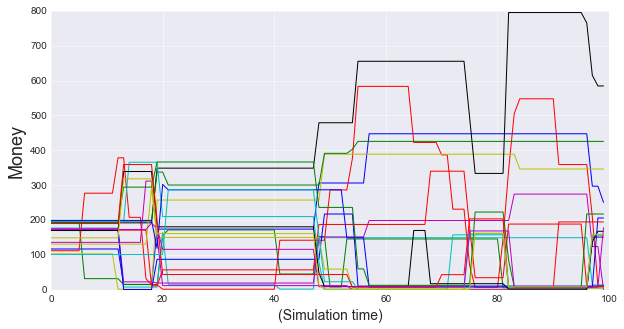

In [34]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

for trader in traderVariables['object_name'].unique():
    ax1.plot(t_time, 
            traderVariables.query('variable_type == "money" and object_name == "{}"'.format(trader))['value'],
            label=trader)

ax1.set_xlabel('(Simulation time)', fontsize='14')
ax1.set_ylabel('Money', fontsize='18')

#plt.legend(loc=2, fontsize='14')

### Stock portfolio:
Likewise the distribution of stocks changes as traders trade with each other. 

In [35]:
import json
import re

In [110]:
traderPortfolios = traderVariables.query('variable_type == "stocks"')
#traderPortfolios['value'] = traderPortfolios['value'].apply(ast.literal_eval)
#traderPortfolios['value'] = traderPortfolios['value'].astype(dict)

In [117]:
s = traderPortfolios['value'][5]
s

'{stock_2: 10, stock_0: 10, stock_3: 10, stock_1: 10}'

In [141]:
original = traderPortfolios['value'][5]
indis = [m.start() for m in re.finditer('stock_', original)]
s = original
counter = 0
for ix in indis:
    ix = ix + counter
    s = s[:ix] + '"' + s[ix:]
    counter += 1
dubbelPunten = [m.start() for m in re.finditer(':', original)]
counter = 0
for dubbelPunt in dubbelPunten:
    ix2 = ix2 + counter
    s = s[:ix2] + '"' + s[ix2:]
    counter += 1
    
s

'{"stock_2"":" 1"0, "stock_0: 10, "stock_3: 10, "stock_1: 10}'

In [133]:
# find the word stock

s = original
ix = s.find('stock_')
s = s[:ix] + '"' + s[ix:]
ix2 = s.find(':')
s = s[:ix2] + '"' + s[ix2:]
s

'{"stock_2": 10, stock_0: 10, stock_3: 10, stock_1: 10}'

In [ ]:
def insterQuotationsInStringDict(stringDict):
    

In [118]:
#s = "{'muffin' : 'lolz', 'foo' : 'kitty'}"
json_acceptable_string = s.replace("'", "\"")
d = json.loads(s)
d

JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)

In [102]:
for element in traderPortfolios['value'].unique():
    print(type(element))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

In [87]:
type(traderPortfolios['value'][5])

str

In [82]:
stocks = {}
for stock in stockVariables['object_name'].unique():
    stocks[stock] = []
    for i in range(len(traderPortfolios)):
        stocks[stock].append(traderPortfolios['value'].iloc[i][stock])
    traderPortfolios[stock] = stocks[stock]
traderPortfolios.tail()

TypeError: string indices must be integers

In [44]:
tp_time = traderPortfolios.query('object_name == "trader_0"')['period']

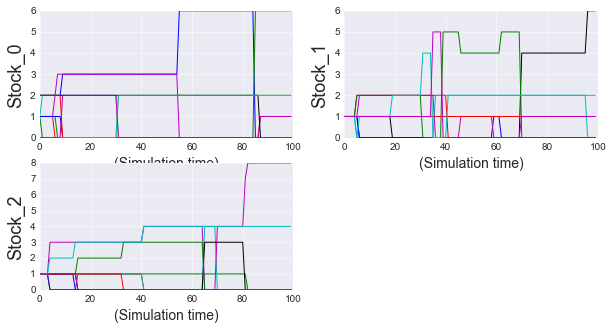

In [49]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

for trader in traderPortfolios['object_name'].unique():
    ax1.plot(tp_time, 
            traderPortfolios.query('object_name == "{}"'.format(trader))['stock_0'],
            label=trader)
    
for trader in traderPortfolios['object_name'].unique():
    ax2.plot(tp_time, 
            traderPortfolios.query('object_name == "{}"'.format(trader))['stock_1'],
            label=trader)
    
for trader in traderPortfolios['object_name'].unique():
    ax3.plot(tp_time, 
            traderPortfolios.query('object_name == "{}"'.format(trader))['stock_2'],
            label=trader)

ax1.set_xlabel('(Simulation time)', fontsize='14')
ax1.set_ylabel('Stock_0', fontsize='18')
ax2.set_xlabel('(Simulation time)', fontsize='14')
ax2.set_ylabel('Stock_1', fontsize='18')
ax3.set_xlabel('(Simulation time)', fontsize='14')
ax3.set_ylabel('Stock_2', fontsize='18')

#plt.legend(loc=2, fontsize='14')

## 2 Transactions
Using the Transactions and Objects tables, I then analyse the transactions made by traders. 

In [36]:
transactions = pd.read_sql_query("""
SELECT Transactions.id, Transactions.period, Transactors.role, Objects.object_name, Objects.object_type, Transactions.amount_of_product, Transactions.amount_of_money 
FROM Transactors JOIN Transactions JOIN Objects 
ON Transactors.transaction_id = Transactions.id and Transactors.transactor_id = Objects.id
""", conn)

The price of transactions is not recorded in the simulation. Therefore, I derive it by dividing the amount of money payed for a single transactions by the amount of stocks traded. 

In [37]:
transactions['price'] = transactions['amount_of_money'] / transactions['amount_of_product']

In [38]:
transactions.tail(10)

,id,period,role,object_name,object_type,amount_of_product,amount_of_money,price
245,82,98,stock,stock_3,stock,2.0,30.437073,15.218537
246,83,98,buyer,trader_2,trader,13.0,197.840977,15.218537
247,83,98,seller,trader_14,trader,13.0,197.840977,15.218537
248,83,98,stock,stock_3,stock,13.0,197.840977,15.218537
249,84,99,buyer,trader_4,trader,8.0,123.997160,15.499645
250,84,99,seller,trader_18,trader,8.0,123.997160,15.499645
251,84,99,stock,stock_3,stock,8.0,123.997160,15.499645
252,85,99,buyer,trader_0,trader,3.0,46.498935,15.499645
253,85,99,seller,trader_18,trader,3.0,46.498935,15.499645
254,85,99,stock,stock_3,stock,3.0,46.498935,15.499645


### 2.1 Prices 
A stock can be traded at different prices at the same time by different traders. I therefore construct a seperate table which summarizes stocks prices over time. 

In [53]:
transactionTime = [n for n in range(100)]

In [54]:
stockPrices = {'period': transactionTime}
for stock in transactions.query('object_type == "stock"')['object_name'].unique():
    allPrices = []
    for period in transactionTime:
        pricesAtPeriod = []
        for price in transactions.query('object_name == "{}" and period == {}'.format(stock,period))['price']:
            pricesAtPeriod.append(price)
        if (not not pricesAtPeriod):
            allPrices.append(pricesAtPeriod)
        else:
            allPrices.append(False)
    stockPrices[stock] = allPrices

In [55]:
pricesOvertime = pd.DataFrame(stockPrices)
pricesOvertime

,period,stock_0,stock_1,stock_2,stock_3
0,0,False,False,False,False
1,1,False,False,False,False
2,2,False,False,False,False
3,3,False,False,False,False
4,4,False,False,False,False
5,5,False,False,False,False
6,6,False,False,[16.5025],False
7,7,False,False,False,False
8,8,False,False,False,False
9,9,False,False,False,False


In [85]:
# To do plot prices over time

In [18]:
cur.close()
conn.close()